In [1]:
# load packages
import csv
import os
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import matplotlib.colors as mcol
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

In [2]:
# load functions
def read_csv_roster(roster_path, columns_to_drop=[]):
    assert(exists(roster_path))
    try: 
        roster = pd.read_csv(roster_path)
    except: 
        raise ValueError('file could not read.')
    roster.drop(columns=columns_to_drop, inplace=True)
    roster.dropna(axis=0, how='all', inplace=True)
    return roster

def show_save_palette(palette_as_list, sort, save=False):
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)
    if sort:
        palette_as_list = sorted(palette_as_list)
        prefix += "_sorted"
    
    palette = np.reshape(palette_as_list, (1, len(palette_as_list), 3)).astype(np.uint8)
    plt.imshow(palette)   
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    
    if save:
        fig1.savefig("final/" + prefix + "_motif_based_palette.png")
    plt.close()
    
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb


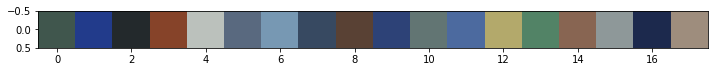

In [3]:
# look at the paletter we are working with
final_palette_df = read_csv_roster("palette.csv", "code")
final_palette_list = final_palette_df.values.tolist()

final_palette_list_hex = []
for i in range(len(final_palette_list)):
    final_palette_list_hex.append(rgb_to_hex(tuple(final_palette_list[i])))
show_save_palette(final_palette_list, sort = False)

In [4]:
# read tulip data (with ground truth)
# and process data for later analysis
tulipfreqwithgttest = read_csv_roster("tulipfreqwithgt.csv")
tulipfreqwithgt = tulipfreqwithgttest[['ID','class', 'perc_0', 'perc_1',
                                       'perc_2','perc_3', 'perc_4', 
                                       'perc_5','perc_6', 'perc_7', 
                                       'perc_8', 'perc_9', 'perc_10', 
                                       'perc_11', 'perc_12', 'perc_13', 
                                       'perc_14', 'perc_15', 'perc_16', 
                                       'perc_17']]
tulipfreqwithgt = tulipfreqwithgt.dropna()
tulipfreqwithgt = tulipfreqwithgt.reset_index(drop=True)
d = {0:'blue_green', 1:'white_red_bluegreen', 2:'blue_red', 3:'blue_red_green',  
     4:'red_white_bluegreen', 5:'red', 6:'unclassified'}
tulipfreqwithgt["gt"] = tulipfreqwithgt['class'].map(d)


In [5]:
# add PCA analysis results to df
pca = PCA(n_components = 3) 
X_principal = pca.fit_transform(tulipfreqwithgt[tulipfreqwithgt.columns[2:20]]) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2', 'P3'] 
tulipfreqwithgtfull = pd.concat([X_principal, tulipfreqwithgt], axis=1)

In [6]:
# get rid of unclassified class in gt
tulipfreqwithgtfull = tulipfreqwithgtfull[tulipfreqwithgtfull['class'] != 6.0] 
# df_filtered = tulipfreqwithgtfull
tulipfreqwithgtfull.head()

,P1,P2,P3,ID,class,perc_0,perc_1,perc_2,perc_3,perc_4,...,perc_9,perc_10,perc_11,perc_12,perc_13,perc_14,perc_15,perc_16,perc_17,gt
0,-9.950392,4.610408,-3.734397,AM03_0000_t,0.0,0.00,20.85,11.82,0.0,12.05,...,0.00,0.00,0.0,0.0,5.71,0.0,0.0,18.66,0.0,blue_green
1,-10.013314,-4.082785,-15.974363,AM03_0001_t,0.0,4.96,0.00,23.58,0.0,13.27,...,0.00,8.35,0.0,0.0,3.23,0.0,0.0,33.58,0.0,blue_green
2,-4.495959,0.357140,-3.076854,AM04_0000_t,0.0,8.42,25.18,0.00,0.0,15.13,...,25.44,6.89,0.0,0.0,7.91,0.0,0.0,0.00,0.0,blue_green
3,-7.924611,-0.437704,-8.891917,AM04_0001_t,0.0,7.42,0.00,10.05,0.0,12.20,...,39.43,8.79,0.0,0.0,7.06,0.0,0.0,0.00,0.0,blue_green
4,-7.912828,4.654592,1.842616,AM04_0002_t,0.0,7.69,42.59,0.00,0.0,12.65,...,0.00,8.29,0.0,0.0,8.06,0.0,0.0,0.00,0.0,blue_green


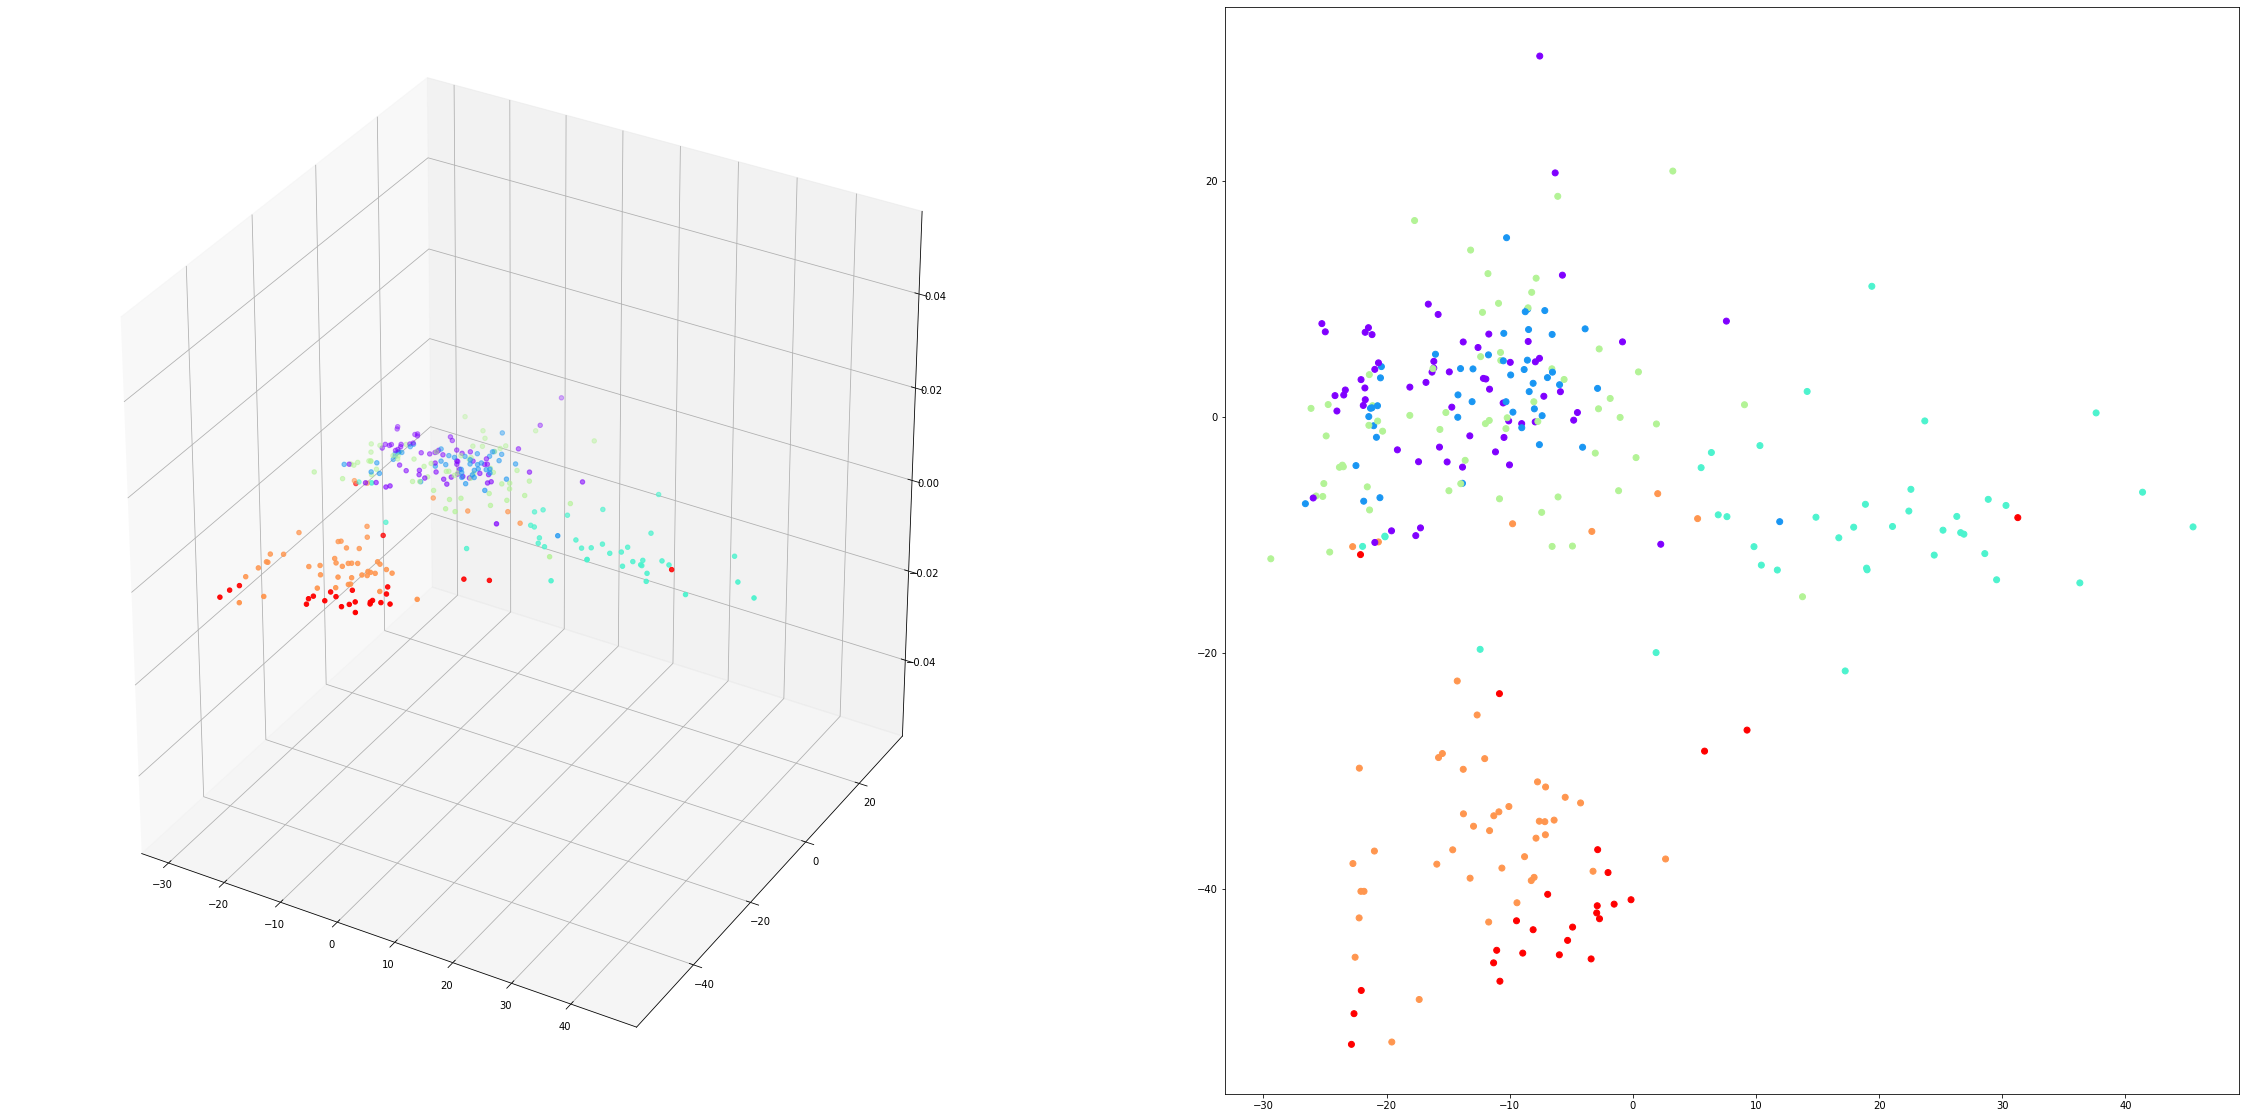

In [7]:
pcadata = tulipfreqwithgtfull[tulipfreqwithgtfull.columns[:3]]
nonpcadata = tulipfreqwithgtfull[tulipfreqwithgtfull.columns[5:23]]

fig = plt.figure(figsize =(40, 20))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)
ax1.scatter(pcadata["P1"],pcadata["P2"], c = tulipfreqwithgtfull['class'], cmap='rainbow')
ax2.scatter(pcadata["P1"],pcadata["P2"], c = tulipfreqwithgtfull['class'], cmap='rainbow')

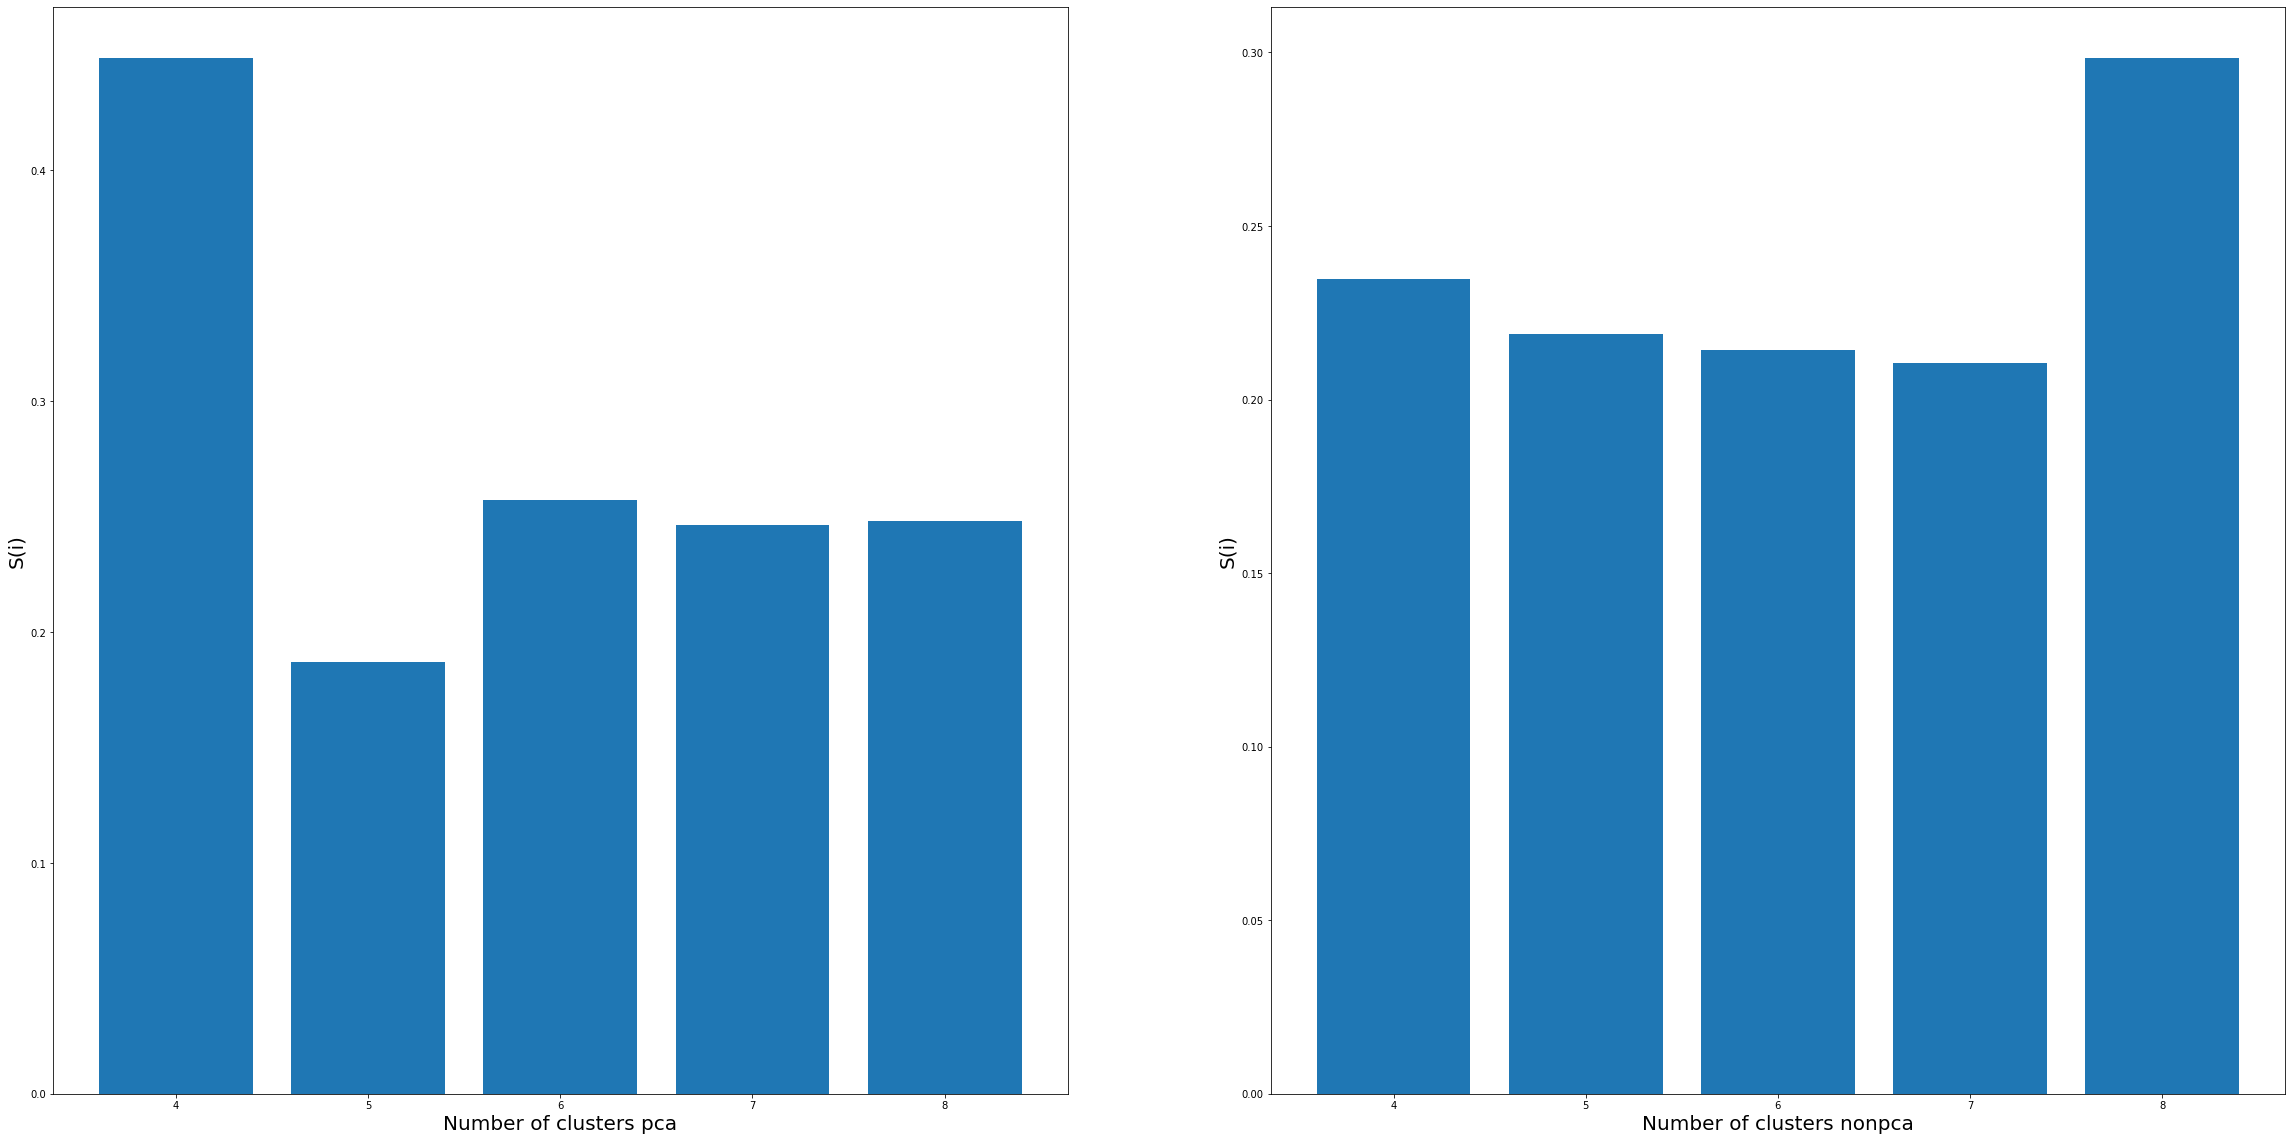

In [8]:
# hcluster
ac4 = AgglomerativeClustering(n_clusters = 4, affinity='cosine', linkage='average') 
ac5 = AgglomerativeClustering(n_clusters = 5, affinity='cosine', linkage='average') 
ac6 = AgglomerativeClustering(n_clusters = 6, affinity='cosine', linkage='average') 
ac7 = AgglomerativeClustering(n_clusters = 7, affinity='cosine', linkage='average') 
ac8 = AgglomerativeClustering(n_clusters = 8, affinity='cosine', linkage='average') 

k = [4, 5, 6, 7, 8]  
# Appending the silhouette scores of pca data
silhouette_scores_pca = [] 
silhouette_scores_pca.append( 
        silhouette_score(pcadata, ac4.fit_predict(pcadata))) 
silhouette_scores_pca.append( 
        silhouette_score(pcadata, ac5.fit_predict(pcadata))) 
silhouette_scores_pca.append( 
        silhouette_score(pcadata, ac6.fit_predict(pcadata))) 
silhouette_scores_pca.append( 
        silhouette_score(pcadata, ac7.fit_predict(pcadata))) 
silhouette_scores_pca.append( 
        silhouette_score(pcadata, ac8.fit_predict(pcadata))) 

# Appending the silhouette scores of nonpca data
silhouette_scores_nonpca = [] 
silhouette_scores_nonpca.append( 
        silhouette_score(nonpcadata, ac4.fit_predict(nonpcadata))) 
silhouette_scores_nonpca.append( 
        silhouette_score(nonpcadata, ac5.fit_predict(nonpcadata))) 
silhouette_scores_nonpca.append( 
        silhouette_score(nonpcadata, ac6.fit_predict(nonpcadata))) 
silhouette_scores_nonpca.append( 
        silhouette_score(nonpcadata, ac7.fit_predict(nonpcadata))) 
silhouette_scores_nonpca.append( 
        silhouette_score(nonpcadata, ac8.fit_predict(nonpcadata))) 


# compare silhouette scores for pca and nonpca data for hcluster
plt.figure(figsize =(40, 20))

ax1 = plt.subplot(121)
fig1 = plt.bar(k, silhouette_scores_pca) 
plt.xlabel('Number of clusters pca', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20)

ax2 = plt.subplot(122)
fig1 = plt.bar(k, silhouette_scores_nonpca) 
plt.xlabel('Number of clusters nonpca', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 

plt.show() 


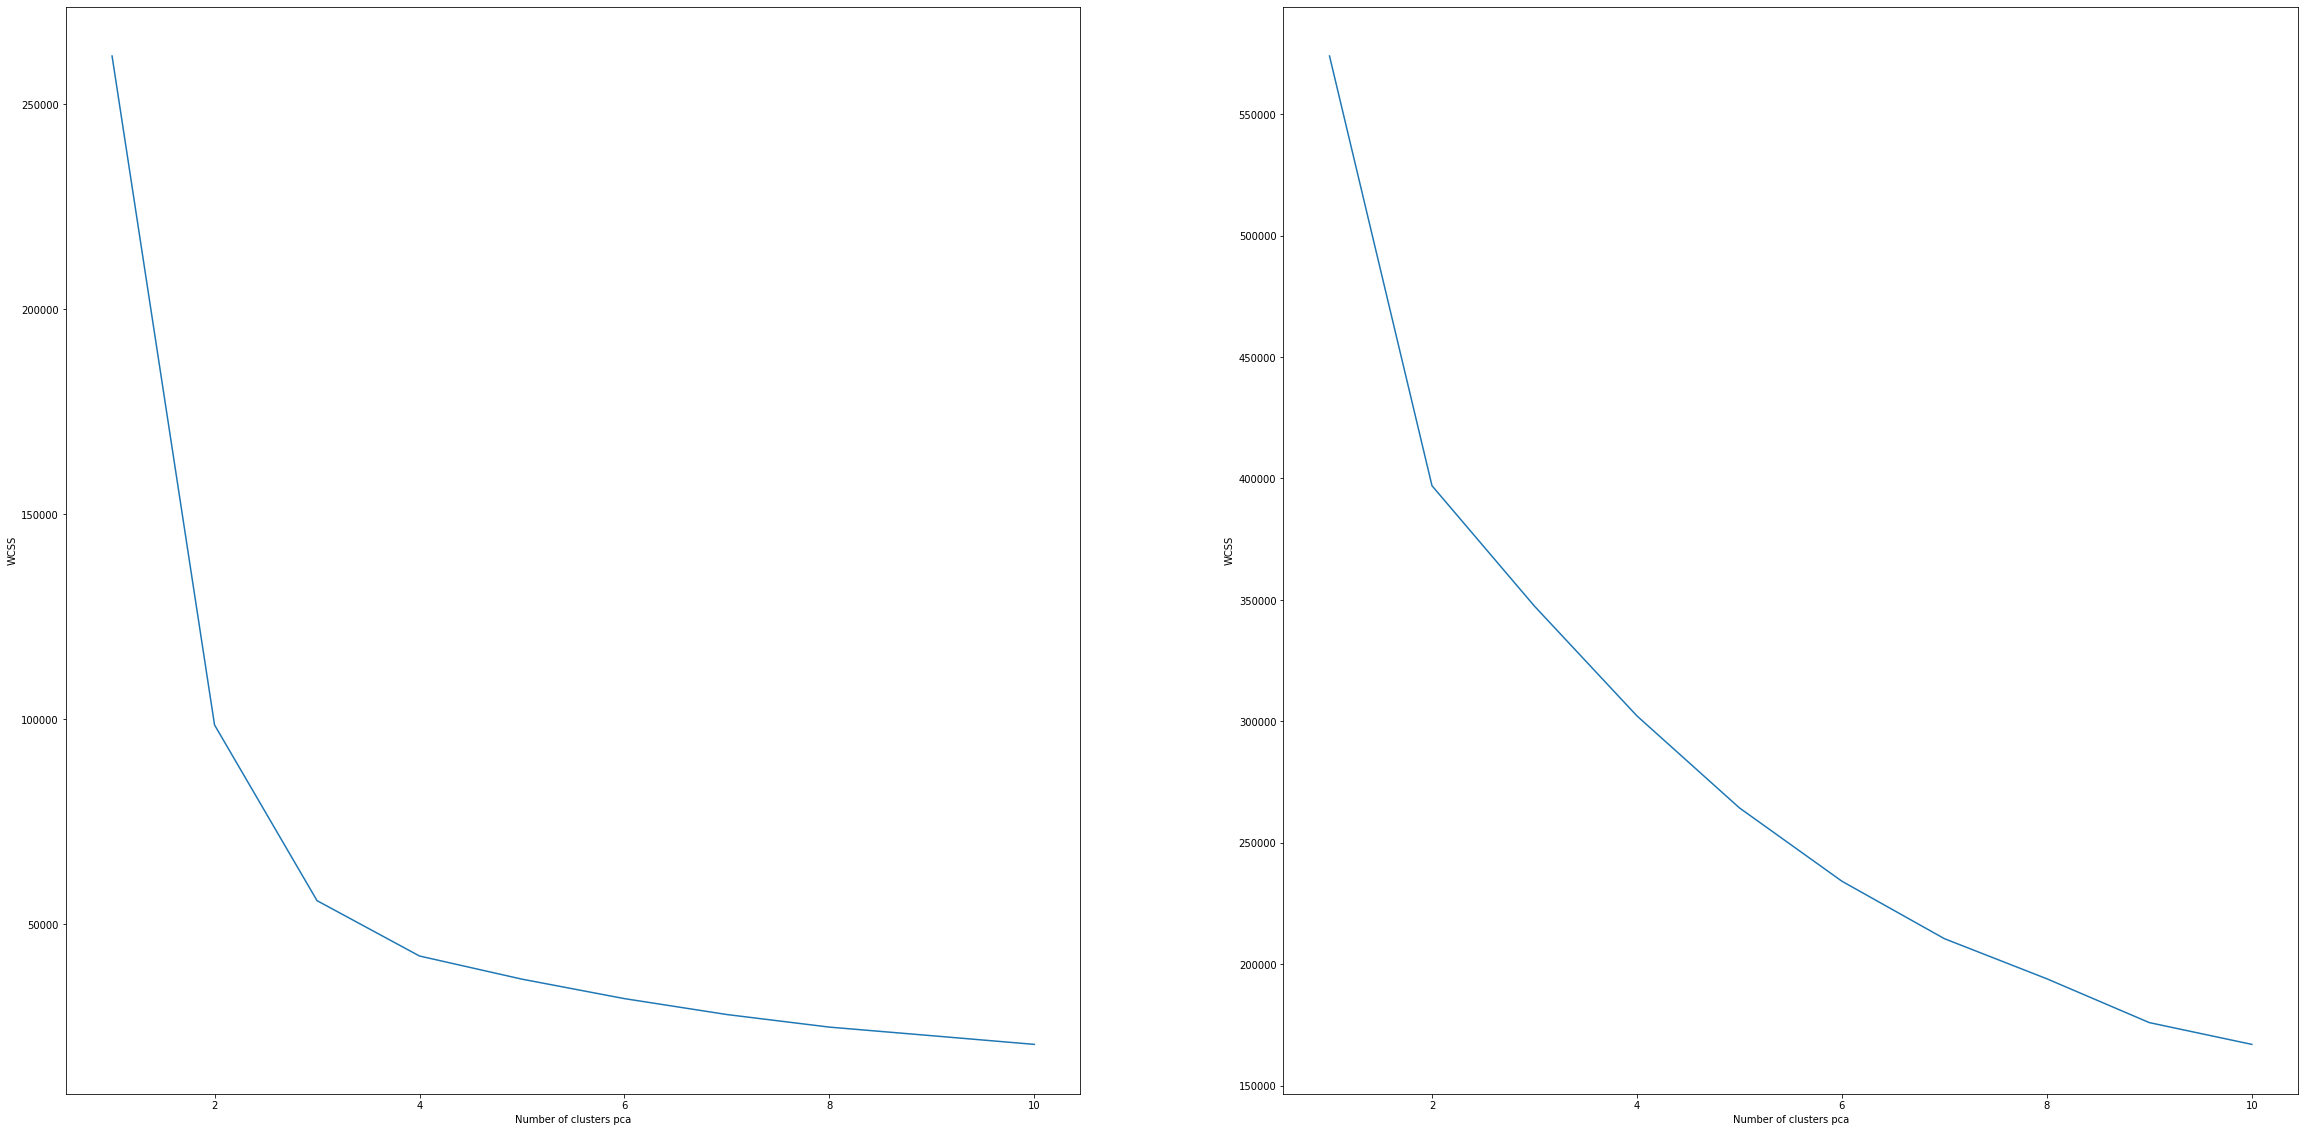

In [9]:
# compare silhouette scores for pca and nonpca data for kmean cluster
# elbow method to find cluster for pca data in kmean
wcsspca = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(pcadata)
    wcsspca.append(kmeans.inertia_)    
# elbow method to find cluster for nonpca data in kmean
wcssnonpca = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
    kmeans.fit(nonpcadata)
    wcssnonpca.append(kmeans.inertia_)

# compare silhouette scores for pca and nonpca data for hcluster
plt.figure(figsize =(40, 20))

ax1 = plt.subplot(121)
fig1 = plt.plot(range(1, 11), wcsspca)
plt.xlabel('Number of clusters pca')
plt.ylabel('WCSS')

ax2 = plt.subplot(122)
fig2 = plt.plot(range(1, 11), wcssnonpca)
plt.xlabel('Number of clusters pca')
plt.ylabel('WCSS')

plt.show() 

In [10]:
# add hcluster(using pca and nonpca, n=4) results in df

# Affinity can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. 
# If linkage is “ward”, only “euclidean” is accepted. 
# If “precomputed”, a distance matrix (instead of a similarity matrix) is needed as input for the fit method.
hcluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward') 
kmeans = KMeans(n_clusters = 6) 

kmeanspca = kmeans.fit_predict(pcadata)
kpcacentre = kmeans.cluster_centers_
kmeansnonpca = kmeans.fit_predict(nonpcadata)
knonpcacentre = kmeans.cluster_centers_
hnonpca = hcluster.fit_predict(tulipfreqwithgtfull[tulipfreqwithgtfull.columns[4:22]])
hpca = hcluster.fit_predict(tulipfreqwithgtfull[tulipfreqwithgtfull.columns[:2]])

tulipfreqwithgtfull['hcluster_nonpca'] = hnonpca
tulipfreqwithgtfull['hcluster_pca'] = hpca
tulipfreqwithgtfull['kcluster_nonpca'] = kmeansnonpca
tulipfreqwithgtfull['kcluster_pca'] = kmeanspca

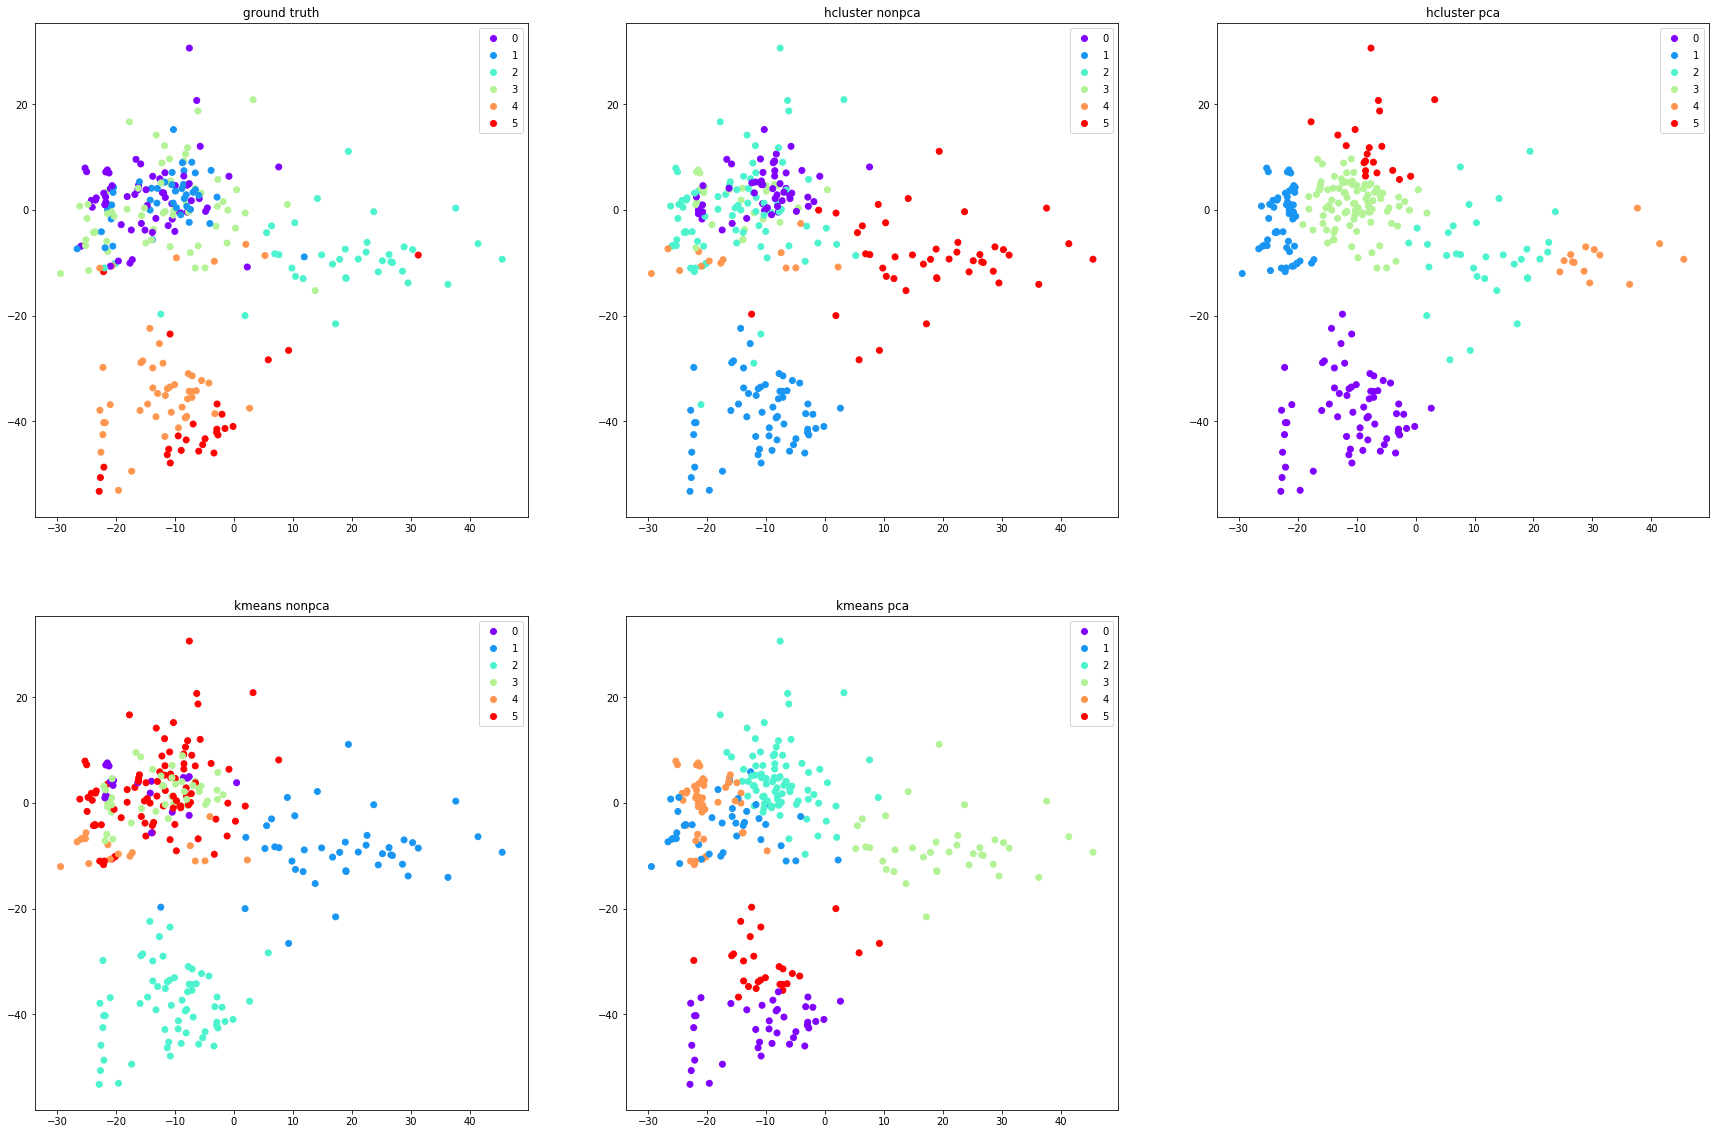

In [11]:
plt.figure(figsize =(30, 20)) 

ax1 = plt.subplot(231)
fig1 = plt.scatter(tulipfreqwithgtfull['P1'], tulipfreqwithgtfull['P2'],  
           c = tulipfreqwithgtfull['class'], cmap='rainbow')
legend = plt.legend(*fig1.legend_elements())
plt.title('ground truth') 

plt.subplot(232, sharex=ax1, sharey=ax1)
fig2 = plt.scatter(tulipfreqwithgtfull['P1'], tulipfreqwithgtfull['P2'],  
           c = tulipfreqwithgtfull['hcluster_nonpca'], cmap='rainbow') 
legend = plt.legend(*fig2.legend_elements())
plt.title('hcluster nonpca') 

plt.subplot(233, sharex=ax1, sharey=ax1)
fig3 = plt.scatter(tulipfreqwithgtfull['P1'], tulipfreqwithgtfull['P2'],  
           c = tulipfreqwithgtfull['hcluster_pca'], cmap='rainbow') 
legend = plt.legend(*fig3.legend_elements())
plt.title('hcluster pca') 

plt.subplot(234, sharex=ax1, sharey=ax1)
fig4 = plt.scatter(tulipfreqwithgtfull['P1'], tulipfreqwithgtfull['P2'],  
           c = tulipfreqwithgtfull['kcluster_nonpca'], cmap='rainbow')
legend = plt.legend(*fig4.legend_elements())
plt.title('kmeans nonpca') 

plt.subplot(235, sharex=ax1, sharey=ax1)
fig5 = plt.scatter(tulipfreqwithgtfull['P1'], tulipfreqwithgtfull['P2'],  
           c = tulipfreqwithgtfull['kcluster_pca'], cmap='rainbow') 
legend = plt.legend(*fig5.legend_elements())
plt.title('kmeans pca') 

plt.show() 
